# Full VE problem analysis template

In [1]:
import os
import sys
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
#import sympy as sym
import torch

sys.path.append('../src')
import deepymod_torch.VE_datagen as VE_datagen
from deepymod_torch.library_function import stress_input_library
from deepymod_torch.DeepMod import DeepMoD
from deepymod_torch.VE_params import coeffs_from_model_params_kelvin, coeffs_from_model_params_maxwell

/opt/conda/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:544: FutureWa

## Data generation

> The below cell is very important for preparing the generation, examination, and saving of the data. It is one of only a few cells that requires configuration in the notebook.

In [2]:
omega = 1
E = [1, 1, 1]
eta = [2.5, 10**-2]
#t = sym.symbols('t', real=True)
#input_expr = sym.sinc(omega*t)
input_expr = lambda t: np.sin(omega*t)/(omega*t)
dsigma = lambda t: (1/t)*(np.cos(omega*t) - np.sin(omega*t)/(omega*t))
input_torch_lambda = lambda t: torch.sin(omega*t)/(omega*t)
input_type = 'Strain'
func_desc = 'Sinc'
time_array = np.linspace(0.00001, 30, 5000)
#np.seed(42)

In [3]:
strain_array, stress_array = VE_datagen.calculate_strain_stress(input_type, time_array, input_expr, E, eta, D_input_lambda=dsigma)

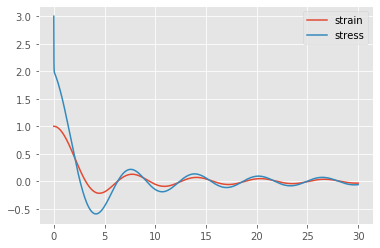

In [4]:
plt.plot(time_array, strain_array.flatten(), label='strain')
plt.plot(time_array, stress_array.flatten(), label='stress')
plt.legend()

## Generation Validation

In [5]:
errors = VE_datagen.equation_residuals(time_array, strain_array, stress_array, E, eta, input_type)

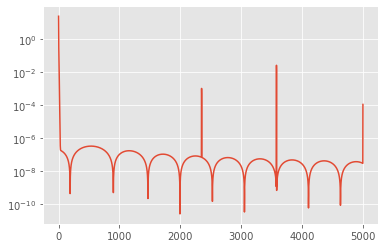

In [6]:
plt.semilogy(abs(errors.flatten()))

## Data Treatment

In [7]:
time_array = time_array.reshape(-1, 1)
strain_array = strain_array.reshape(-1, 1)

In [8]:
noise_level = 0
noisy_strain_array = strain_array + noise_level * np.std(strain_array) * np.random.standard_normal(strain_array.shape)

In [9]:
number_of_samples = 1000

reordered_row_indices = np.random.permutation(time_array.size)
reduced_time_array = time_array[reordered_row_indices, :][:number_of_samples]
reduced_strain_array = noisy_strain_array[reordered_row_indices, :][:number_of_samples]

## DeepMod prep

In [10]:
time_tensor = torch.tensor(reduced_time_array, dtype=torch.float32, requires_grad=True)
strain_tensor = torch.tensor(reduced_strain_array, dtype=torch.float32)

In [11]:
optim_config = {'lambda': 10**-6, 'max_iterations': 101, 'final_run_iterations': 11}

In [12]:
network_config = {'input_dim': 1, 'hidden_dim': 25, 'layers': 5, 'output_dim': 1}

In [13]:
lib_config = {'type': stress_input_library, 'diff_order': 3, 'coeff_sign': 'positive', 'input_type': input_type, 'input_expr': input_torch_lambda}

## Running DeepMoD

In [14]:
if input_type == 'Stress':
    not_floats = coeffs_from_model_params_kelvin(E, eta)
elif input_type == 'Strain':
    not_floats = coeffs_from_model_params_maxwell(E, eta)
        
[float(x) for x in not_floats]

[0.19920318725099603,
 0.014940239043824702,
 0.19920318725099603,
 0.5,
 0.004980079681274901]

In [15]:
now = datetime.now()

In [16]:
sparse_coeff_vector_list_list, scaled_coeff_vector_list_list, sparsity_mask_list_list, network = DeepMoD(time_tensor, strain_tensor, network_config, lib_config, optim_config)

Epoch | Total loss | MSE | PI | L1 
0 1.2E-01 7.5E-02 4.1E-02 1.2E-04
tensor([[0.1985],
        [0.8760],
        [1.2580],
        [0.2567],
        [1.8715],
        [0.8284],
        [0.3465]], requires_grad=True)
lrs are 0.001 0.001
Time elapsed: 0.0 minutes 0.10695719718933105 seconds
[tensor([[0.0874],
        [0.7626],
        [1.1774],
        [0.3474],
        [1.7773],
        [0.7386],
        [0.4422]], requires_grad=True)] [tensor([[0.0874],
        [0.7626],
        [1.1774],
        [0.3474],
        [1.7773],
        [0.7386],
        [0.4422]], requires_grad=True)] [tensor([0, 1, 2, 3, 4, 5, 6])]
Now running final cycle.
Epoch | Total loss | MSE | PI | L1 
0 2.2E-02 6.2E-03 1.6E-02 0.0E+00
tensor([[0.0874],
        [0.7626],
        [1.1774],
        [0.3474],
        [1.7773],
        [0.7386],
        [0.4422]], requires_grad=True)
lrs are 0.001 0.001
Time elapsed: 0.0 minutes 0.08503437042236328 seconds


### Results

In [17]:
sparse_coeff_vector_list_list

[[tensor([[0.0874],
          [0.7626],
          [1.1774],
          [0.3474],
          [1.7773],
          [0.7386],
          [0.4422]], requires_grad=True)], [tensor([[0.0765],
          [0.7516],
          [1.1666],
          [0.3584],
          [1.7663],
          [0.7277],
          [0.4532]], requires_grad=True)]]

In [18]:
sparsity_mask_list_list

[[tensor([0, 1, 2, 3, 4, 5, 6])], [tensor([0, 1, 2, 3, 4, 5, 6])]]

## Results Processing

> Run as far as here in one shot, then check that the below two code cells are correct, in particular, the string, `success_state` cannot be preset.

In [19]:
success_state = 'Fail'

In [20]:
investigated_param = 'Decay Constant 2'
param_value = 10**-2
repeat_instance = 99

> From here, you can run the rest of the code.

In [21]:
stress_array = stress_array.reshape(-1,1)
reduced_stress_array = stress_array[reordered_row_indices, :][:number_of_samples]

prediction_array = np.array(network(time_tensor).detach())

if `prediction_coeffs_array` is not equal dimensionally to the `target_coeffs_array`, there would be an error if it weren't for the `if` statement prempting this. In the case where the dimensions don't agree, there is no sensible way to assess these quantities anyway, so this data is mostly abandoned. The coeffs before thresholding are however saved as `pre_thresh_coeffs_array`.

In [22]:
target_coeffs_array = np.array(not_floats).reshape(-1,1)
pre_thresh_coeffs_array = np.array(sparse_coeff_vector_list_list[0][0].detach())
final_coeffs_array = np.array(sparse_coeff_vector_list_list[-1][0].detach())
good_dims = False
if target_coeffs_array.shape == final_coeffs_array.shape:
    coeffs_ME = np.sum(abs(target_coeffs_array - final_coeffs_array))/len(not_floats)
    coeffs_ME = np.array(coeffs_ME).reshape(1)
    sparsity_mask_array = np.array(sparsity_mask_list_list[-1][0]).reshape(-1,1)
    good_dims = True

if statement just bypasses errors

In [23]:
series_data = np.concatenate((reduced_time_array, reduced_strain_array, reduced_stress_array, prediction_array), axis=1)
if good_dims:
    coeffs_data = np.concatenate((target_coeffs_array, final_coeffs_array, sparsity_mask_array), axis=1)

In [24]:
dt_string = now.strftime('%d/%m/%Y %H:%M:%S')

In [25]:
DG_info_list = [str(omega), str(E), str(eta), input_type, func_desc]
DG_info_list

['1', '[1, 1, 1]', '[2.5, 0.01]', 'Strain', 'Sinc']

In [26]:
misc_list = [dt_string, investigated_param, str(param_value), str(repeat_instance), success_state]
misc_list

['10/02/2020 15:47:08', 'Decay Constant 2', '0.01', '99', 'Fail']

## Saving

In [27]:
first_subfolder = investigated_param
second_subfolder = 'param_' + str(param_value).replace('.', '-')
third_subfolder = 'repeat_' + str(repeat_instance)

parent_folder = '../data/Results'

foldername = parent_folder + '/' + first_subfolder + '/' + second_subfolder + '/' + third_subfolder

In [28]:
if not os.path.isdir(foldername):
    os.makedirs(foldername)

In [29]:
np.savetxt(foldername+'/series_data.csv', series_data, delimiter=',', header='Time, Target_Strain, Stress, Prediction_Strain')
np.savetxt(foldername+'/pre_thresh_coeffs.csv', pre_thresh_coeffs_array, delimiter=',')

if statement just bypasses errors

In [30]:
if good_dims:
    np.savetxt(foldername+'/coeffs_data.csv', coeffs_data, delimiter=',', header='Target_Coeffs, Prediction_Coeffs, Sparsity_Mask')
    np.savetxt(foldername+'/error.csv', coeffs_ME, delimiter=',')

In [31]:
with open(foldername+'/misc_list.txt', 'w') as file:
    file.writelines("%s\n" % line for line in misc_list)

In [32]:
with open(foldername+'/DG_info_list.txt', 'w') as file:
    file.writelines("%s\n" % line for line in DG_info_list)